## Validation test on different protein

In [ ]:
import numpy as np
import os, random, time
import pandas as pd
from pathlib import Path
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

def get_files(input_list):
    out_list=[]
    if type(input_list)==type(None):
        return out_list
    for item in input_list:
        
        if os.path.isdir(item):
            out_list.extend(list(Path(item).rglob("*.npz")))

        elif item[-4:]=='.npz':
            out_list.append(item)        
    
    random.seed(0)
    random.shuffle(out_list)
    return out_list

def read_from_file(file_name):
    data=np.load(file_name)
    return data['morgan1'],data['morgan2'],data['morgan3'], data['protein'], data['labels']

def generate_batches(files, batch_size=1024):
    counter = 0
    
    print_freq=max(1, len(files)//10)
    
    while counter<len(files):
        file_name = files[counter]

        counter +=1
        
        data=read_from_file(file_name)

        morgan1, morgan2, morgan3, protein, labels=data
        batch_size=max(batch_size,1)
        for local_index in range(0, labels.shape[0], batch_size):
            batch_morgan1=morgan1[local_index:(local_index + batch_size)]
            batch_morgan2=morgan2[local_index:(local_index + batch_size)]
            batch_morgan3=morgan3[local_index:(local_index + batch_size)]
            batch_protein=protein[local_index:(local_index + batch_size)]
            batch_labels=labels[local_index:(local_index + batch_size)]          

            yield batch_morgan1, batch_morgan2, batch_morgan3, batch_protein, batch_labels
        
        if counter%print_freq==0:
            print('.', end='',flush=True)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim, Tensor

from torch.nn.parallel import DataParallel

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1=nn.Linear(3075,2048)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2=nn.Linear(2048,1024)
        self.dropout3 = nn.Dropout(0.2)
        self.fc4=nn.Linear(1024,512)
        self.fc5=nn.Linear(512,128)
        self.out=nn.Linear(128,1)
        
    def forward(self, x):
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=F.relu(self.fc4(x))
        x=F.relu(self.fc5(x))
        out=self.out(x)
        return out

In [7]:
model_load_path = "/mnt/isilon/wang_lab/shared/Belka/analysis/saved_models/bldblock_NN_epoch_8.pth"
checkpoint = torch.load(model_load_path)

# load the model and continue training
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
net = Net().to(dev)
net = DataParallel(net) #do this because previous model is within DataParallel
net.load_state_dict(checkpoint['model_state_dict'])


optimizer = optim.Adam(net.parameters(), lr=0.001)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#loss = loss.load_state_dict(checkpoint['loss'])

In [22]:
test_files=get_files(['morgan_validation_complete/'])
print('num of validation_file: ',len(test_files))

num of validation_file:  119


In [23]:
%%time
with torch.no_grad():
    net.eval()
    preds = []
    labels = []
    proteins = []
    test_loss = 0
    test_generator = generate_batches(test_files, batch_size=50000)
    for batch in test_generator:
        batch_morgan1, batch_morgan2, batch_morgan3, batch_protein, batch_labels = batch
        batch_morgan = np.concatenate((batch_morgan1, batch_morgan2, batch_morgan3, batch_protein), 1)
        score = net(torch.Tensor(batch_morgan).to(dev))
        #loss = torch.nn.functional.binary_cross_entropy_with_logits(score, torch.Tensor(batch_labels)[:, None].to(dev), pos_weight=pos_weight_vali)
        
        preds.append(torch.sigmoid(score).cpu().numpy())
        labels.append(batch_labels)
        proteins.append(batch_protein)
        #test_loss += loss.cpu().item() * len(score)

    preds = np.vstack(preds)[:, 0]
    labels = np.hstack(labels)
    proteins = np.vstack(proteins)

    # Calculate additional metrics
    ap = average_precision_score(labels, preds)
    roc_auc = roc_auc_score(labels, preds)

    print(f'Test AP={ap:.6f} ROC_AUC={roc_auc:.6f}')



..........Test AP=0.639679 ROC_AUC=0.986233
CPU times: user 5min 37s, sys: 3min 29s, total: 9min 6s
Wall time: 12min 6s


In [30]:
preds

array([4.2627672e-08, 9.7955370e-01, 9.9566805e-01, ..., 1.4888950e-07,
       3.0479138e-04, 8.3507366e-06], dtype=float32)

In [26]:
labels

array([0, 1, 1, ..., 0, 0, 0], dtype=int8)

In [27]:
proteins

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1]], dtype=int8)

In [28]:
np.savez('bldblock_NN_epoch_8_validation_save.npz', 
         preds=preds,labels=labels,proteins=proteins)

In [40]:
p_map = {'BRD4': 0, 'HSA': 1, 'sEH': 2}
protein_names = ['BRD4', 'HSA', 'sEH']

In [47]:
np.sum(proteins,axis=0)

array([19681160, 19678117, 19685434])

In [42]:
import numpy as np
from sklearn.metrics import average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt

Average Precision for BRD4: 0.5306
Average Precision for HSA: 0.3901
Average Precision for sEH: 0.8234


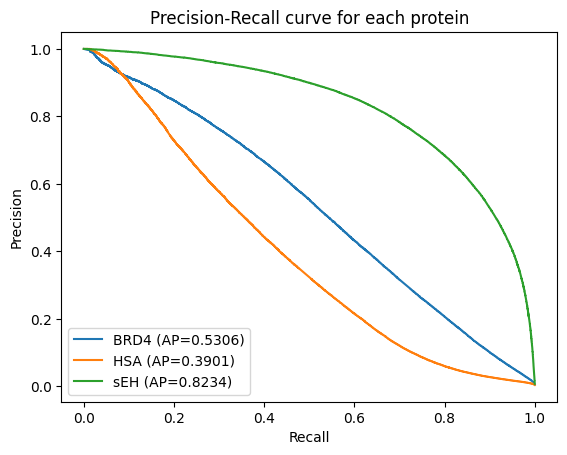

In [44]:
# Plot precision-recall curves for each protein in one plot
plt.figure()

for protein_name, protein_idx in p_map.items():
    # Filter data for the current protein
    protein_filter = proteins[:, protein_idx] == 1
    protein_preds = preds[protein_filter]
    protein_labels = labels[protein_filter]

    # Calculate average precision
    ap = average_precision_score(protein_labels, protein_preds)
    print(f'Average Precision for {protein_name}: {ap:.4f}')

    # Calculate precision-recall curve
    precision, recall, _ = precision_recall_curve(protein_labels, protein_preds)

    # Plot precision-recall curve
    plt.plot(recall, precision, label=f'{protein_name} (AP={ap:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for each protein (bdb_NN_epoch8)')
plt.legend()
plt.show()